In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from textblob import TextBlob
from wordcloud import WordCloud
import re, ast, sys
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import streamlit as st

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Msi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Msi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
raw_interactions_df = pd.read_csv(r"D:\Practice\Food Recommendation System\RAW_interactions.csv")
raw_interactions_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [7]:
raw_recipes_df = pd.read_csv(r"D:\Practice\Food Recommendation System\RAW_recipes.csv")
raw_recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [8]:
raw_interactions_df.shape

(1132367, 5)

In [9]:
raw_recipes_df.shape

(231637, 12)

In [10]:
combined_df = raw_recipes_df.merge(raw_interactions_df, left_on='id', right_on='recipe_id')
combined_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ..."
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...


In [11]:
combined_df.drop(["submitted","contributor_id","id"],axis=1,inplace=True)

final_df = combined_df.reindex(columns=['recipe_id', 'name', 'date', 'user_id', 'minutes', 'tags', 'nutrition', 'n_steps', 'description', 'ingredients', 'n_ingredients', 'rating', 'review'])
final_df.head()

,recipe_id,name,date,user_id,minutes,tags,nutrition,n_steps,description,ingredients,n_ingredients,rating,review
0,137739,arriba baked winter squash mexican style,2006-02-18,4470,55,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5,I used an acorn squash and recipe#137681 Swee...
1,137739,arriba baked winter squash mexican style,2010-08-21,593927,55,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5,This was a nice change. I used butternut squas...
2,137739,arriba baked winter squash mexican style,2011-12-05,178427,55,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5,Excellent recipe! I used butternut squash and ...
3,31490,a bit different breakfast pizza,2002-08-19,28603,30,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,0,"Have not tried this, but it sounds delicious. ..."
4,31490,a bit different breakfast pizza,2006-08-27,346277,30,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,5,This recipe was wonderful. Instead of using t...


In [12]:
final_df = final_df.fillna('NA')

In [13]:
final_df.info()
final_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   recipe_id      1132367 non-null  int64 
 1   name           1132367 non-null  object
 2   date           1132367 non-null  object
 3   user_id        1132367 non-null  int64 
 4   minutes        1132367 non-null  int64 
 5   tags           1132367 non-null  object
 6   nutrition      1132367 non-null  object
 7   n_steps        1132367 non-null  int64 
 8   description    1132367 non-null  object
 9   ingredients    1132367 non-null  object
 10  n_ingredients  1132367 non-null  int64 
 11  rating         1132367 non-null  int64 
 12  review         1132367 non-null  object
dtypes: int64(6), object(7)
memory usage: 112.3+ MB


recipe_id        0
name             0
date             0
user_id          0
minutes          0
tags             0
nutrition        0
n_steps          0
description      0
ingredients      0
n_ingredients    0
rating           0
review           0
dtype: int64

In [14]:
subset_df = final_df.sample(30000)
subset_df.head()

,recipe_id,name,date,user_id,minutes,tags,nutrition,n_steps,description,ingredients,n_ingredients,rating,review
872368,19653,roll out cookies,2010-01-10,1516444,25,"['30-minutes-or-less', 'time-to-make', 'course...","[1870.6, 147.0, 402.0, 50.0, 43.0, 296.0, 77.0]",12,my favorite cookie recipe to use with cookie c...,"['butter', 'sugar', 'egg', 'baking powder', 'v...",6,5,I made this with almond extract instead of van...
990202,254299,super creamy and cheesy mac and cheese,2017-10-17,44749290,10,"['15-minutes-or-less', 'time-to-make', 'course...","[291.5, 23.0, 2.0, 14.0, 22.0, 47.0, 9.0]",6,i always make a big batch of this because my h...,"['elbow macaroni', 'milk', 'flour', 'salt and ...",6,5,"GREAT &amp; EASY, this is a real time saver an..."
195172,269925,charmie s soft sugar cookies,2010-11-04,1648250,150,"['time-to-make', 'course', 'cuisine', 'prepara...","[1092.1, 76.0, 267.0, 61.0, 30.0, 53.0, 49.0]",8,i know there are a ton of sugar cookie recipes...,"['margarine', 'sugar', 'eggs', 'vanilla', 'flo...",7,5,Left them unfrosted and served them with raspb...
837446,89164,quick yeast bread,2015-07-24,2000359672,80,"['time-to-make', 'course', 'cuisine', 'prepara...","[1433.6, 48.0, 20.0, 49.0, 74.0, 20.0, 82.0]",9,"if you don't have a bread machine, this is the...","['all-purpose white flour', 'yeast', 'sugar', ...",6,5,I&#039;m making this recipe for the first time...
548081,72640,inside out bacon cheeseburgers with grilled gr...,2010-11-06,140132,35,"['bacon', '60-minutes-or-less', 'time-to-make'...","[1093.3, 117.0, 23.0, 60.0, 105.0, 142.0, 15.0]",19,this is just like a traditional bacon cheesebu...,"['bacon', 'scallions', 'extra virgin olive oil...",12,5,These are fantastic burgers. I made these yes...


In [15]:
def calculate_difficulty(n_steps):
    if n_steps <= 5:
        return 'Easy'
    elif 6 <= n_steps <= 10:
        return 'Medium'
    else:
        return 'Hard'

subset_df['difficulty'] = subset_df['n_steps'].apply(calculate_difficulty)

In [16]:
# 2. Parse ingredients and tags
def preprocess_column(value, split=False):
    if pd.isna(value):
        return []
    if split:
        return [item.strip() for item in value.split(',')]
    else:
        try:
            import ast
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return []

subset_df['ingredients'] = subset_df['ingredients'].apply(lambda x: preprocess_column(x, split=True))
subset_df['tags'] = subset_df['tags'].apply(lambda x: preprocess_column(x))

In [17]:
# --- NLP for User Preferences ---
import string
def preprocess_text(text):

    #1 Remove Punctuation
    #2 Remove stopwords

    #1
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)

    #2
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    spamwords=[word for word in nopunc.split() if word.lower in stopwords.words('english')]

    return clean_words

subset_df['cleaned_review'] = subset_df['review'].apply(preprocess_text)

In [18]:
# 3. Infer dietary restrictions from nutrition
subset_df['nutrition'] = subset_df['nutrition'].apply(lambda x: eval(x) if isinstance(x, str) else x)
nutrition_columns = ['calories','total fat','sugar','sodium','protein','saturated fat','carbohydrates']
subset_df[nutrition_columns]= pd.DataFrame(subset_df['nutrition'].tolist(), index=subset_df.index)

# Verify the columns
print(subset_df[nutrition_columns].describe())

           calories     total fat         sugar        sodium       protein  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean     457.271797     34.086567     79.629033     31.725467     35.083267   
std      655.532915     60.208025    246.649169    190.287662     46.938533   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      178.800000      9.000000      9.000000      6.000000      7.000000   
50%      313.100000     20.000000     24.000000     16.000000     18.000000   
75%      511.125000     40.000000     68.000000     35.000000     53.000000   
max    30933.400000   2406.000000  14495.000000  29338.000000   2638.000000   

       saturated fat  carbohydrates  
count   30000.000000   30000.000000  
mean       43.297600      15.075067  
std        78.681071      29.915705  
min         0.000000       0.000000  
25%         7.000000       4.000000  
50%        23.000000       9.000000  
75%        51.000000  

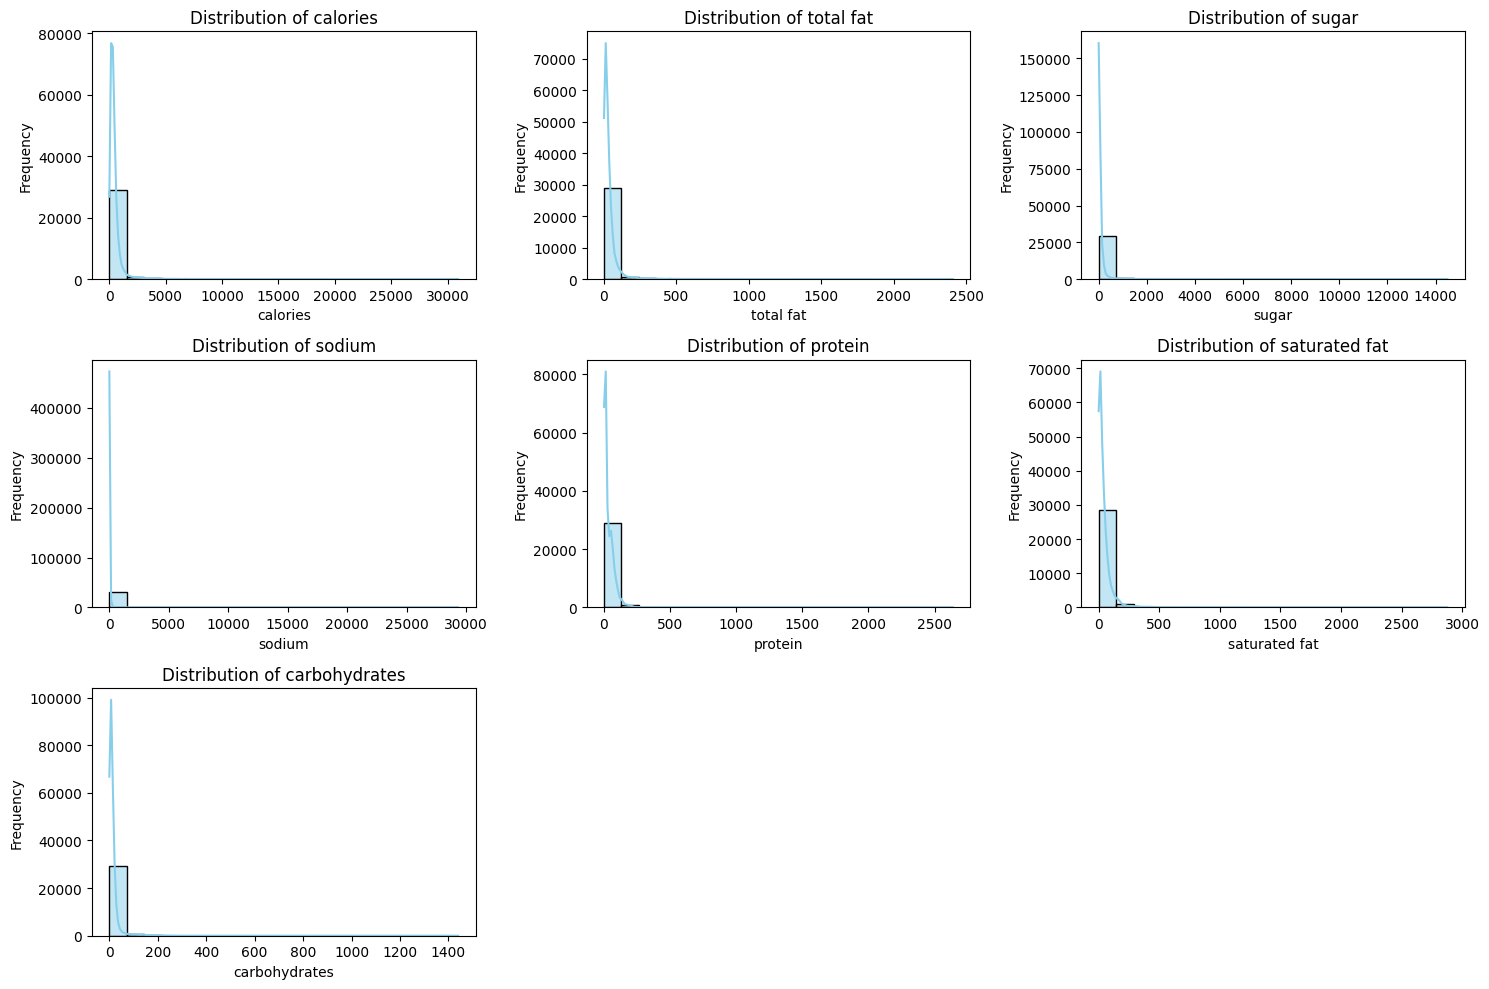

In [19]:
# Set up the plotting environment
plt.figure(figsize=(15, 10))
for i, col in enumerate(nutrition_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(subset_df[col], bins=20, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show() 

In [20]:
# Calculate quantile thresholds for each metric
thresholds = {
    'calories': subset_df['calories'].quantile(0.75),       # High calorie if above 75th percentile
    'protein': subset_df['protein'].quantile(0.75),         # High protein if above 75th percentile
    'carbohydrates': subset_df['carbohydrates'].quantile(0.25),  # Low carb if below 25th percentile
    'sugar': subset_df['sugar'].quantile(0.75),             # High sugar if above 75th percentile
    'saturated_fat': subset_df['saturated fat'].quantile(0.75),  # High saturated fat if above 75th percentile
    'total_fat': subset_df['total fat'].quantile(0.75),     # High fat if above 75th percentile
}

# Print thresholds for review
print("Thresholds for dietary tags:")
for key, value in thresholds.items():
    print(f"{key}: {value}")

Thresholds for dietary tags:
calories: 511.125
protein: 53.0
carbohydrates: 4.0
sugar: 68.0
saturated_fat: 51.0
total_fat: 40.0


In [21]:
# Function to assign dietary tags
def assign_dietary_tags(row):
    tags = []
    if row['calories'] > thresholds['calories']:
        tags.append('High Calorie')
    if row['protein'] > thresholds['protein']:
        tags.append('High Protein')
    if row['carbohydrates'] < thresholds['carbohydrates']:
        tags.append('Low Carb')
    if row['sugar'] > thresholds['sugar']:
        tags.append('High Sugar')
    if row['saturated fat'] > thresholds['saturated_fat']:
        tags.append('High Saturated Fat')
    if row['total fat'] > thresholds['total_fat']:
        tags.append('High Fat')
    return tags

# Apply function to the DataFrame
subset_df['dietary_tags'] = subset_df.apply(assign_dietary_tags, axis=1)

# Review the resulting dietary tags
print(subset_df[['name', 'dietary_tags']].head())

                                                     name  \
872368                                   roll out cookies   
990202             super creamy and cheesy mac and cheese   
195172                       charmie s soft sugar cookies   
837446                                  quick yeast bread   
548081  inside out bacon cheeseburgers with grilled gr...   

                                             dietary_tags  
872368  [High Calorie, High Sugar, High Saturated Fat,...  
990202                                                 []  
195172  [High Calorie, High Sugar, High Saturated Fat,...  
837446             [High Calorie, High Protein, High Fat]  
548081  [High Calorie, High Protein, High Saturated Fa...  


In [22]:
def extract_dietary_tags(row):
    try:
        # Convert tags from string to list if necessary
        tags = ast.literal_eval(row['tags']) if isinstance(row['tags'], str) else row['tags']
    except (ValueError, SyntaxError):
        tags = []  # Handle invalid or empty tags gracefully

    # Create regex patterns for keywords with adjectives like high/low
    patterns = [fr"(?:high|low|reduced|free)?\s*{keyword}" for keyword in nutrition_columns]
    
    # Find tags that match the patterns
    dietary_tags = [tag for tag in tags if any(re.search(pattern, tag, re.IGNORECASE) for pattern in patterns)]
    return dietary_tags

def update_dietary_tags(row):
    # Extract new dietary tags using the function
    new_tags = extract_dietary_tags(row)
    # Combine existing and new tags
    combined_tags = set(row['dietary_tags'] + new_tags)  # Use set to avoid duplicates
    return list(combined_tags)  # Convert back to list for consistency

# Apply the function to update dietary_tgs
subset_df['dietary_tags'] = subset_df.apply(update_dietary_tags, axis=1)
print(subset_df['dietary_tags'])

872368     [High Sugar, High Saturated Fat, High Fat, Hig...
990202                                                    []
195172     [High Sugar, High Saturated Fat, High Fat, Hig...
837446                [High Protein, High Fat, High Calorie]
548081     [High Protein, High Saturated Fat, High Fat, H...
                                 ...                        
1049676                                           [Low Carb]
406111     [High Sugar, High Fat, High Calorie, High Prot...
738325                                          [High Sugar]
562665                             [low-sodium, low-protein]
1130101                                        [low-protein]
Name: dietary_tags, Length: 30000, dtype: object


C:\Users\Msi\AppData\Local\Temp\ipykernel_11692\989788599.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette='Set2')


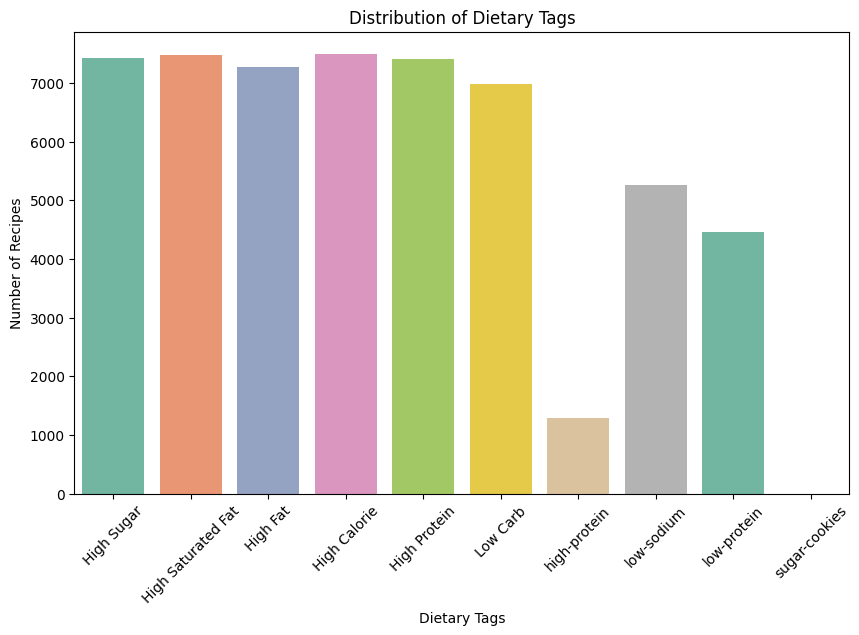

In [23]:
from collections import Counter

# Count occurrences of each dietary tag
all_tags = [tag for tags in subset_df['dietary_tags'] for tag in tags]
tag_counts = Counter(all_tags)

# Plot tag distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette='Set2')
plt.title("Distribution of Dietary Tags")
plt.xlabel("Dietary Tags")
plt.ylabel("Number of Recipes")
plt.xticks(rotation=45)
plt.show() 

In [24]:
subset_df['cleaned_review'] = subset_df['cleaned_review'].apply(lambda x: ', '.join(map(str, x)))
subset_df.head()

,recipe_id,name,date,user_id,minutes,tags,nutrition,n_steps,description,ingredients,...,difficulty,cleaned_review,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,dietary_tags
872368,19653,roll out cookies,2010-01-10,1516444,25,"[30-minutes-or-less, time-to-make, course, pre...","[1870.6, 147.0, 402.0, 50.0, 43.0, 296.0, 77.0]",12,my favorite cookie recipe to use with cookie c...,"[['butter', 'sugar', 'egg', 'baking powder', '...",...,Hard,"made, almond, extract, instead, vanilla, stuck...",1870.6,147.0,402.0,50.0,43.0,296.0,77.0,"[High Sugar, High Saturated Fat, High Fat, Hig..."
990202,254299,super creamy and cheesy mac and cheese,2017-10-17,44749290,10,"[15-minutes-or-less, time-to-make, course, mai...","[291.5, 23.0, 2.0, 14.0, 22.0, 47.0, 9.0]",6,i always make a big batch of this because my h...,"[['elbow macaroni', 'milk', 'flour', 'salt and...",...,Medium,"GREAT, amp, EASY, real, time, saver, quick, en...",291.5,23.0,2.0,14.0,22.0,47.0,9.0,[]
195172,269925,charmie s soft sugar cookies,2010-11-04,1648250,150,"[time-to-make, course, cuisine, preparation, o...","[1092.1, 76.0, 267.0, 61.0, 30.0, 53.0, 49.0]",8,i know there are a ton of sugar cookie recipes...,"[['margarine', 'sugar', 'eggs', 'vanilla', 'fl...",...,Medium,"Left, unfrosted, served, raspberry, jam, Delic...",1092.1,76.0,267.0,61.0,30.0,53.0,49.0,"[High Sugar, High Saturated Fat, High Fat, Hig..."
837446,89164,quick yeast bread,2015-07-24,2000359672,80,"[time-to-make, course, cuisine, preparation, h...","[1433.6, 48.0, 20.0, 49.0, 74.0, 20.0, 82.0]",9,"if you don't have a bread machine, this is the...","[['all-purpose white flour', 'yeast', 'sugar',...",...,Medium,"I039m, making, recipe, first, time, first, eve...",1433.6,48.0,20.0,49.0,74.0,20.0,82.0,"[High Protein, High Fat, High Calorie]"
548081,72640,inside out bacon cheeseburgers with grilled gr...,2010-11-06,140132,35,"[bacon, 60-minutes-or-less, time-to-make, cour...","[1093.3, 117.0, 23.0, 60.0, 105.0, 142.0, 15.0]",19,this is just like a traditional bacon cheesebu...,"[['bacon', 'scallions', 'extra virgin olive oi...",...,Hard,"fantastic, burgers, made, yesterday, family, g...",1093.3,117.0,23.0,60.0,105.0,142.0,15.0,"[High Protein, High Saturated Fat, High Fat, H..."


In [25]:
# Sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

subset_df['sentiment'] = subset_df['cleaned_review'].apply(analyze_sentiment)
subset_df['sentiment_label'] = subset_df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

In [26]:
subset_df.info()
subset_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 872368 to 1130101
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recipe_id        30000 non-null  int64  
 1   name             30000 non-null  object 
 2   date             30000 non-null  object 
 3   user_id          30000 non-null  int64  
 4   minutes          30000 non-null  int64  
 5   tags             30000 non-null  object 
 6   nutrition        30000 non-null  object 
 7   n_steps          30000 non-null  int64  
 8   description      30000 non-null  object 
 9   ingredients      30000 non-null  object 
 10  n_ingredients    30000 non-null  int64  
 11  rating           30000 non-null  int64  
 12  review           30000 non-null  object 
 13  difficulty       30000 non-null  object 
 14  cleaned_review   30000 non-null  object 
 15  calories         30000 non-null  float64
 16  total fat        30000 non-null  float64
 17  sugar     

recipe_id          0
name               0
date               0
user_id            0
minutes            0
tags               0
nutrition          0
n_steps            0
description        0
ingredients        0
n_ingredients      0
rating             0
review             0
difficulty         0
cleaned_review     0
calories           0
total fat          0
sugar              0
sodium             0
protein            0
saturated fat      0
carbohydrates      0
dietary_tags       0
sentiment          0
sentiment_label    0
dtype: int64

In [27]:
modified_df = subset_df.copy()
modified_df.head()

,recipe_id,name,date,user_id,minutes,tags,nutrition,n_steps,description,ingredients,...,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,dietary_tags,sentiment,sentiment_label
872368,19653,roll out cookies,2010-01-10,1516444,25,"[30-minutes-or-less, time-to-make, course, pre...","[1870.6, 147.0, 402.0, 50.0, 43.0, 296.0, 77.0]",12,my favorite cookie recipe to use with cookie c...,"[['butter', 'sugar', 'egg', 'baking powder', '...",...,1870.6,147.0,402.0,50.0,43.0,296.0,77.0,"[High Sugar, High Saturated Fat, High Fat, Hig...",0.086667,positive
990202,254299,super creamy and cheesy mac and cheese,2017-10-17,44749290,10,"[15-minutes-or-less, time-to-make, course, mai...","[291.5, 23.0, 2.0, 14.0, 22.0, 47.0, 9.0]",6,i always make a big batch of this because my h...,"[['elbow macaroni', 'milk', 'flour', 'salt and...",...,291.5,23.0,2.0,14.0,22.0,47.0,9.0,[],0.342708,positive
195172,269925,charmie s soft sugar cookies,2010-11-04,1648250,150,"[time-to-make, course, cuisine, preparation, o...","[1092.1, 76.0, 267.0, 61.0, 30.0, 53.0, 49.0]",8,i know there are a ton of sugar cookie recipes...,"[['margarine', 'sugar', 'eggs', 'vanilla', 'fl...",...,1092.1,76.0,267.0,61.0,30.0,53.0,49.0,"[High Sugar, High Saturated Fat, High Fat, Hig...",0.333333,positive
837446,89164,quick yeast bread,2015-07-24,2000359672,80,"[time-to-make, course, cuisine, preparation, h...","[1433.6, 48.0, 20.0, 49.0, 74.0, 20.0, 82.0]",9,"if you don't have a bread machine, this is the...","[['all-purpose white flour', 'yeast', 'sugar',...",...,1433.6,48.0,20.0,49.0,74.0,20.0,82.0,"[High Protein, High Fat, High Calorie]",0.291667,positive
548081,72640,inside out bacon cheeseburgers with grilled gr...,2010-11-06,140132,35,"[bacon, 60-minutes-or-less, time-to-make, cour...","[1093.3, 117.0, 23.0, 60.0, 105.0, 142.0, 15.0]",19,this is just like a traditional bacon cheesebu...,"[['bacon', 'scallions', 'extra virgin olive oi...",...,1093.3,117.0,23.0,60.0,105.0,142.0,15.0,"[High Protein, High Saturated Fat, High Fat, H...",0.575000,positive


In [28]:
modified_df['ingredients'].iloc[0]

["['butter'", "'sugar'", "'egg'", "'baking powder'", "'vanilla'", "'flour']"]

In [29]:
# Define a function to identify meal type based on reviews
def identify_meal_type(row):
    # print(row)
    tags = row['tags']
    # print(tags)
    # print(tags.type)
    review = row['cleaned_review']
    meal_types = ['breakfast', 'brunch', 'lunch', 'snacks', 'dinner', 'desserts', 'other']
    
    # Check for meal type keywords in tags or reviews
    for meal in meal_types:
        if any(meal in tag.lower() for tag in tags):  # Check each tag in the list
            return meal
    
    # Check for meal type keywords in review
    for meal in meal_types:
        if re.search(meal, review, re.IGNORECASE):  # Check for keywords in review
            return meal
    
    return 'other'

def identify_cuisine(row):
    # print(row)
    tags = row['tags']
    cuisine = ['indian', 'italian', 'chinese', 'continental', 'mexican', 'japanese', 'thai', 'mediterranean', 'other']
    
    # Check for meal type keywords in tags or reviews
    for meal in cuisine:
        if any(meal in tag.lower() for tag in tags):  # Check each tag in the list
            return meal
    
    return 'other'

# Define a function to determine preference (veg or non-veg)
def determine_preference(row):
    non_veg_items = [
        'chicken', 'beef', 'pork', 'fish', 'egg', 'eggs', 'lamb', 
        'bacon', 'sausage', 'shrimp', 'turkey', 'salmon', 'crab', 'mutton', 'lobster'
    ]
    veg_keywords = ['veg', 'vegetarian', 'vegan']
    
    # Convert tags and ingredients to lowercase for comparison
    ingredients_lower = [ingredient.lower() for ingredient in row['ingredients']]
    tags_lower = [tag.lower() for tag in row['tags']]
    name_lower = row['name'].lower()
    
    # Check recipe name for non-veg items
    if any(item in name_lower for item in non_veg_items):
        return 'non-veg'
    
    # Check tags for veg/vegetarian/vegan keywords
    if any(veg_keyword in tag for veg_keyword in veg_keywords for tag in tags_lower):
        return 'veg'
    
    # Check ingredients for non-veg items
    if any(item in ingredients_lower for item in non_veg_items):
        return 'non-veg'
    
    # Default to veg if no non-veg items are found
    return 'veg'

# Function to clean ingredient names
def clean_ingredient_name(ingredient):
    if pd.isna(ingredient):
        return None
    return ingredient.strip("[]'\"").lower()  # Remove brackets, quotes, and convert to lowercase

# Function to extract liked and disliked ingredients
def extract_preferences(row):
    liked = []
    disliked = []
    for ingredient in row['ingredients']:
        cleaned_ingredient = clean_ingredient_name(ingredient)
        if row['sentiment'] > 0:
            liked.append(cleaned_ingredient)
        elif row['sentiment'] < 0:
            disliked.append(cleaned_ingredient)
    return pd.Series([liked, disliked])


# Apply functions to extract preferences
modified_df[['liked_ingredients', 'disliked_ingredients']] = modified_df.apply(extract_preferences, axis=1)

# Add meal_type column
modified_df['cuisine'] = modified_df.apply(identify_cuisine, axis=1)

# Add meal_type column
modified_df['meal_type'] = modified_df.apply(identify_meal_type, axis=1)

# Add preference (veg/non-veg) column
modified_df['preference'] = modified_df.apply(determine_preference, axis=1)

In [30]:
modified_df.head()

,recipe_id,name,date,user_id,minutes,tags,nutrition,n_steps,description,ingredients,...,saturated fat,carbohydrates,dietary_tags,sentiment,sentiment_label,liked_ingredients,disliked_ingredients,cuisine,meal_type,preference
872368,19653,roll out cookies,2010-01-10,1516444,25,"[30-minutes-or-less, time-to-make, course, pre...","[1870.6, 147.0, 402.0, 50.0, 43.0, 296.0, 77.0]",12,my favorite cookie recipe to use with cookie c...,"[['butter', 'sugar', 'egg', 'baking powder', '...",...,296.0,77.0,"[High Sugar, High Saturated Fat, High Fat, Hig...",0.086667,positive,"[butter, sugar, egg, baking powder, vanilla, f...",[],other,desserts,veg
990202,254299,super creamy and cheesy mac and cheese,2017-10-17,44749290,10,"[15-minutes-or-less, time-to-make, course, mai...","[291.5, 23.0, 2.0, 14.0, 22.0, 47.0, 9.0]",6,i always make a big batch of this because my h...,"[['elbow macaroni', 'milk', 'flour', 'salt and...",...,47.0,9.0,[],0.342708,positive,"[elbow macaroni, milk, flour, salt and pepper,...",[],other,lunch,veg
195172,269925,charmie s soft sugar cookies,2010-11-04,1648250,150,"[time-to-make, course, cuisine, preparation, o...","[1092.1, 76.0, 267.0, 61.0, 30.0, 53.0, 49.0]",8,i know there are a ton of sugar cookie recipes...,"[['margarine', 'sugar', 'eggs', 'vanilla', 'fl...",...,53.0,49.0,"[High Sugar, High Saturated Fat, High Fat, Hig...",0.333333,positive,"[margarine, sugar, eggs, vanilla, flour, bakin...",[],other,desserts,veg
837446,89164,quick yeast bread,2015-07-24,2000359672,80,"[time-to-make, course, cuisine, preparation, h...","[1433.6, 48.0, 20.0, 49.0, 74.0, 20.0, 82.0]",9,"if you don't have a bread machine, this is the...","[['all-purpose white flour', 'yeast', 'sugar',...",...,20.0,82.0,"[High Protein, High Fat, High Calorie]",0.291667,positive,"[all-purpose white flour, yeast, sugar, salt, ...",[],other,other,veg
548081,72640,inside out bacon cheeseburgers with grilled gr...,2010-11-06,140132,35,"[bacon, 60-minutes-or-less, time-to-make, cour...","[1093.3, 117.0, 23.0, 60.0, 105.0, 142.0, 15.0]",19,this is just like a traditional bacon cheesebu...,"[['bacon', 'scallions', 'extra virgin olive oi...",...,142.0,15.0,"[High Protein, High Saturated Fat, High Fat, H...",0.575000,positive,"[bacon, scallions, extra virgin olive oil, gro...",[],other,dinner,non-veg


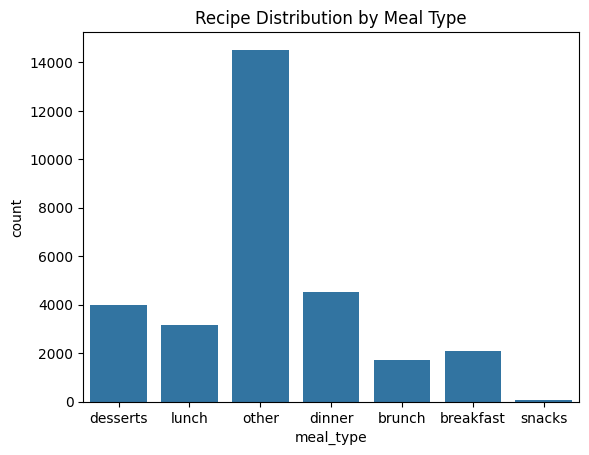

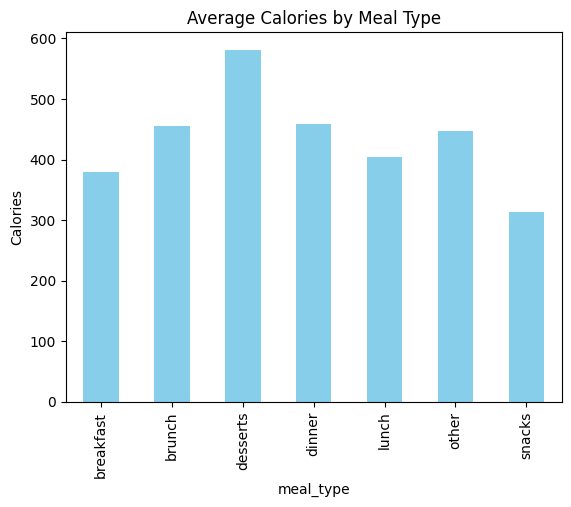

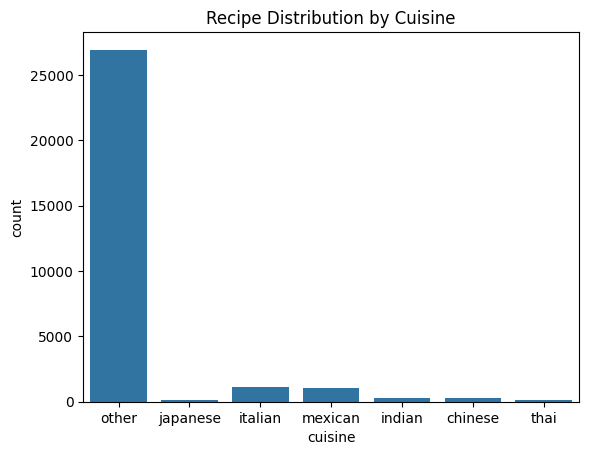

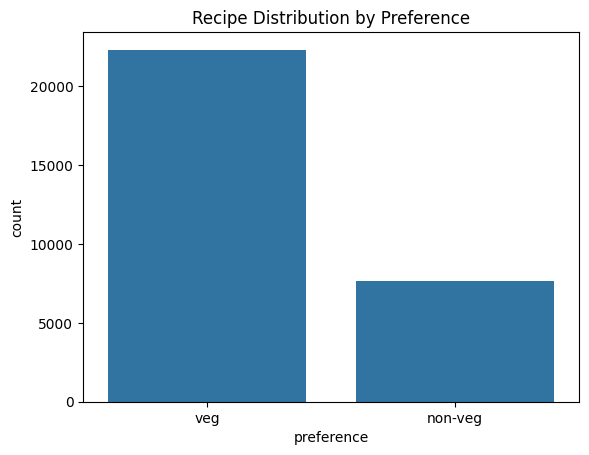

In [31]:
# Plot recipe distribution by meal type
sns.countplot(x='meal_type', data=modified_df)
plt.title("Recipe Distribution by Meal Type")
plt.show()   

# Visualize average nutrition (calories) by meal type
modified_df.groupby('meal_type')['calories'].mean().plot(kind='bar', color='skyblue')
plt.title("Average Calories by Meal Type")
plt.ylabel("Calories")
plt.show() 

# Plot recipe distribution by cuisine
sns.countplot(x='cuisine', data=modified_df)
plt.title("Recipe Distribution by Cuisine")
plt.show()  

# Plot recipe distribution by preference
sns.countplot(x='preference', data=modified_df)
plt.title("Recipe Distribution by Preference")
plt.show()  

In [32]:
# Flatten the lists of liked and disliked ingredients
liked_exploded = modified_df.explode('liked_ingredients')['liked_ingredients'].dropna()
disliked_exploded = modified_df.explode('disliked_ingredients')['disliked_ingredients'].dropna()

# Count occurrences
liked_counts = liked_exploded.value_counts().reset_index()
liked_counts.columns = ['ingredient', 'liked_count']

disliked_counts = disliked_exploded.value_counts().reset_index()
disliked_counts.columns = ['ingredient', 'disliked_count']

# Merge liked and disliked counts
ingredient_counts = pd.merge(
    liked_counts, disliked_counts, on='ingredient', how='outer'
).fillna(0)

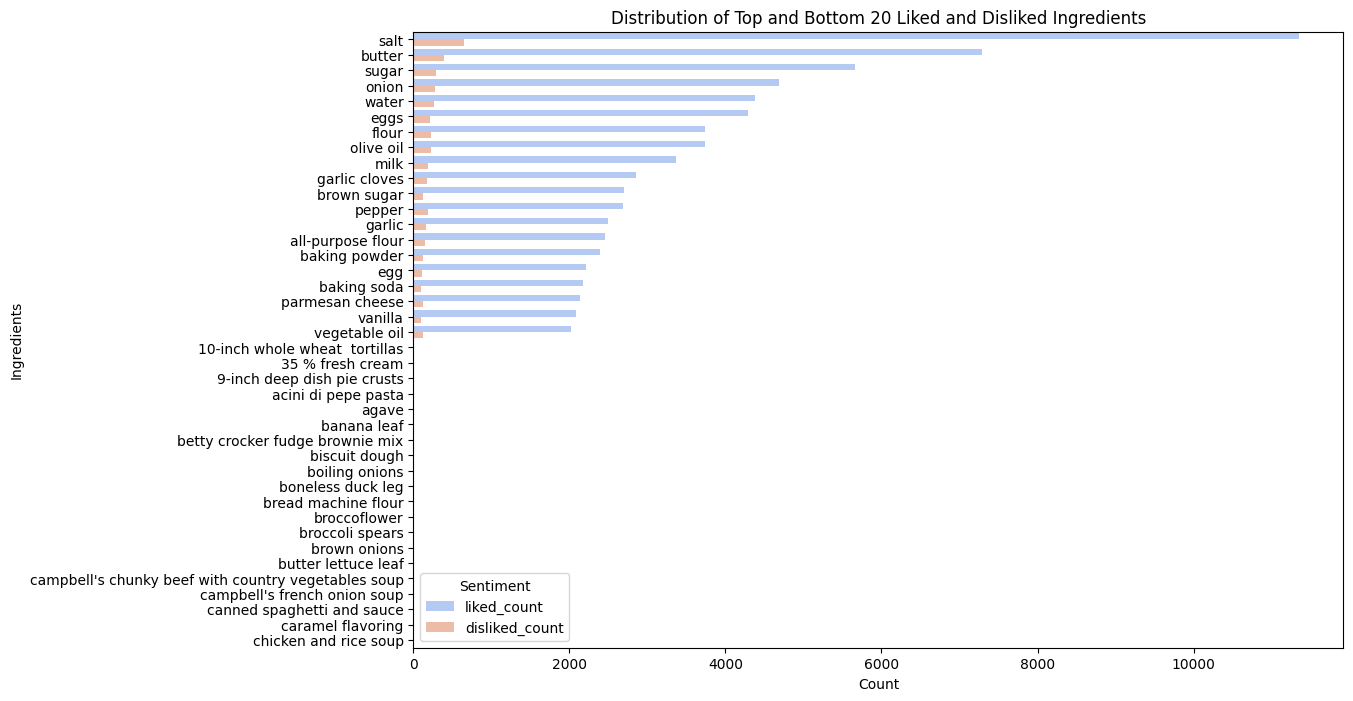

In [33]:
# Normalize counts for heatmap
ingredient_counts['liked_count_norm'] = ingredient_counts['liked_count'] / ingredient_counts['liked_count'].sum()
ingredient_counts['disliked_count_norm'] = ingredient_counts['disliked_count'] / ingredient_counts['disliked_count'].sum()

# Select top 20 and bottom 20 ingredients by liked and disliked counts
top_20 = ingredient_counts.nlargest(20, 'liked_count')
bottom_20 = ingredient_counts.nsmallest(20, 'liked_count')
top_bottom_20 = pd.concat([top_20, bottom_20])

# Plotting a bar plot for popularity (Top and Bottom 20)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_bottom_20.melt(id_vars='ingredient', value_vars=['liked_count', 'disliked_count']),
    x='value', y='ingredient', hue='variable', palette='coolwarm'
)
plt.title("Distribution of Top and Bottom 20 Liked and Disliked Ingredients")
plt.xlabel("Count")
plt.ylabel("Ingredients")
plt.legend(title="Sentiment")
plt.show() 

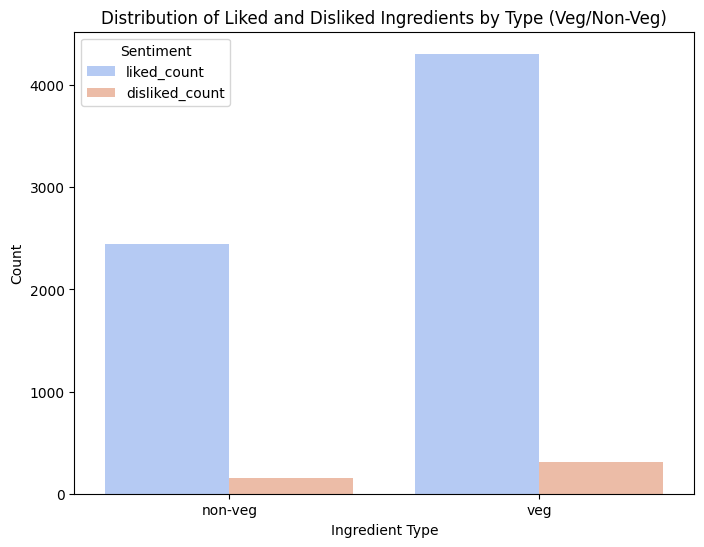

In [34]:
# Add veg/non-veg classification to the ingredient counts
ingredient_counts['type'] = modified_df['preference']

# Aggregate liked and disliked counts by type (Veg/Non-Veg)
type_distribution = ingredient_counts.groupby('type')[['liked_count', 'disliked_count']].sum().reset_index()

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(
    data=type_distribution.melt(id_vars='type', value_vars=['liked_count', 'disliked_count']),
    x='type', y='value', hue='variable', palette='coolwarm'
)
plt.title("Distribution of Liked and Disliked Ingredients by Type (Veg/Non-Veg)")
plt.xlabel("Ingredient Type")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.show() 

In [50]:
modified_df.columns

Index(['recipe_id', 'name', 'date', 'user_id', 'minutes', 'tags', 'nutrition',
       'n_steps', 'description', 'ingredients', 'n_ingredients', 'rating',
       'review', 'difficulty', 'cleaned_review', 'calories', 'total fat',
       'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates',
       'dietary_tags', 'sentiment', 'sentiment_label', 'liked_ingredients',
       'disliked_ingredients', 'cuisine', 'meal_type', 'preference'],
      dtype='object')

In [92]:
columns_to_drop = ['calories', 'total fat',
       'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates', 'sentiment', 'sentiment_label']
recommendation_df = modified_df.drop(columns=columns_to_drop)
recommendation_df = recommendation_df.reset_index(drop=True)

In [93]:
recommendation_df.head()

,recipe_id,name,date,user_id,minutes,tags,nutrition,n_steps,description,ingredients,...,rating,review,difficulty,cleaned_review,dietary_tags,liked_ingredients,disliked_ingredients,cuisine,meal_type,preference
0,19653,roll out cookies,2010-01-10,1516444,25,"[30-minutes-or-less, time-to-make, course, pre...","[1870.6, 147.0, 402.0, 50.0, 43.0, 296.0, 77.0]",12,my favorite cookie recipe to use with cookie c...,"[['butter', 'sugar', 'egg', 'baking powder', '...",...,5,I made this with almond extract instead of van...,Hard,"made, almond, extract, instead, vanilla, stuck...","[High Sugar, High Saturated Fat, High Fat, Hig...","[butter, sugar, egg, baking powder, vanilla, f...",[],other,desserts,veg
1,254299,super creamy and cheesy mac and cheese,2017-10-17,44749290,10,"[15-minutes-or-less, time-to-make, course, mai...","[291.5, 23.0, 2.0, 14.0, 22.0, 47.0, 9.0]",6,i always make a big batch of this because my h...,"[['elbow macaroni', 'milk', 'flour', 'salt and...",...,5,"GREAT &amp; EASY, this is a real time saver an...",Medium,"GREAT, amp, EASY, real, time, saver, quick, en...",[],"[elbow macaroni, milk, flour, salt and pepper,...",[],other,lunch,veg
2,269925,charmie s soft sugar cookies,2010-11-04,1648250,150,"[time-to-make, course, cuisine, preparation, o...","[1092.1, 76.0, 267.0, 61.0, 30.0, 53.0, 49.0]",8,i know there are a ton of sugar cookie recipes...,"[['margarine', 'sugar', 'eggs', 'vanilla', 'fl...",...,5,Left them unfrosted and served them with raspb...,Medium,"Left, unfrosted, served, raspberry, jam, Delic...","[High Sugar, High Saturated Fat, High Fat, Hig...","[margarine, sugar, eggs, vanilla, flour, bakin...",[],other,desserts,veg
3,89164,quick yeast bread,2015-07-24,2000359672,80,"[time-to-make, course, cuisine, preparation, h...","[1433.6, 48.0, 20.0, 49.0, 74.0, 20.0, 82.0]",9,"if you don't have a bread machine, this is the...","[['all-purpose white flour', 'yeast', 'sugar',...",...,5,I&#039;m making this recipe for the first time...,Medium,"I039m, making, recipe, first, time, first, eve...","[High Protein, High Fat, High Calorie]","[all-purpose white flour, yeast, sugar, salt, ...",[],other,other,veg
4,72640,inside out bacon cheeseburgers with grilled gr...,2010-11-06,140132,35,"[bacon, 60-minutes-or-less, time-to-make, cour...","[1093.3, 117.0, 23.0, 60.0, 105.0, 142.0, 15.0]",19,this is just like a traditional bacon cheesebu...,"[['bacon', 'scallions', 'extra virgin olive oi...",...,5,These are fantastic burgers. I made these yes...,Hard,"fantastic, burgers, made, yesterday, family, g...","[High Protein, High Saturated Fat, High Fat, H...","[bacon, scallions, extra virgin olive oil, gro...",[],other,dinner,non-veg


In [94]:
recommendation_df.to_csv("Sorted Recommendation.csv")

In [95]:
# --- Recommendation Functions ---
# Content-Based Filtering
def content_based_recommendation(preferences, df, n_recommendations=5):
    # Extract user preferences
    user_ingredients = preferences.get('ingredients', [])
    user_dietary_tags = preferences.get('dietary_restrictions', [])
    user_tags = preferences.get('tags', [])
    
    # Build TF-IDF matrix for ingredients
    vectorizer = TfidfVectorizer(stop_words='english')
    ingredients_tfidf = vectorizer.fit_transform(df['ingredients'].apply(lambda x: ' '.join(x)))
    
    # Calculate similarity with user preferences
    user_profile = ' '.join(user_ingredients)
    user_vector = vectorizer.transform([user_profile])
    similarity = cosine_similarity(user_vector, ingredients_tfidf).flatten()
    
    # Filter based on dietary tags and other constraints
    filtered_df = df[
        (df['dietary_tags'].apply(lambda x: any(tag in user_dietary_tags for tag in x))) &
        (df['tags'].apply(lambda x: any(tag in user_tags for tag in x))) 
    ].copy()
    
    # Rank by similarity
    filtered_df['similarity'] = similarity[filtered_df.index]
    recommendations = filtered_df.sort_values('similarity', ascending=False).head(n_recommendations)
    
    return recommendations[['name', 'ingredients', 'minutes', 'tags', 'difficulty', 'similarity']]

In [96]:
# Collaborative Filtering
def collaborative_filtering(preferences, df, n_recommendations=5):
    # Filter recipes based on user constraints

    df = df.sort_values(by='user_id').reset_index(drop=True)
    user_item_matrix = modified_df.pivot_table(index='user_id', columns='name', values='rating', fill_value=0)
    print(user_item_matrix.shape)
    
    if user_item_matrix.shape[1] < 2:
        return "Insufficient data for collaborative filtering."
    
    # Apply SVD
    svd = TruncatedSVD(n_components=min(50, user_item_matrix.shape[1] - 1), random_state=42)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_
    predicted_ratings = np.dot(user_factors, item_factors)
    
    # Rank recommendations
    # avg_predicted_ratings = predicted_ratings.mean(axis=0)  # Average predictions for items across all users
    recommended_indices = np.argsort(predicted_ratings)[::-1][:n_recommendations]  # Top-N indices
    
    print(recommended_indices)
    recommended_indices = recommended_indices[recommended_indices < user_item_matrix.shape[1]]
    recommended_titles = user_item_matrix.columns[recommended_indices]

    # Filter Recommendations
    filtered_recommendations = df[df['name'].isin(recommended_titles)]
    print("Filtered Recommendations:")
    print(filtered_recommendations.head())
    
    return filtered_recommendations[['name', 'ingredients', 'minutes', 'tags', 'difficulty', 'rating']]


In [99]:
# Hybrid Recommendation
def hybrid_recommendation(preferences, df, alpha=0.5, n_recommendations=5):
    content_recommendations = content_based_recommendation(preferences, df, n_recommendations * 2)
    print("Content-Based Recommendations:", content_recommendations)
    
    # Ensure 'name' column is a string
    df['name'] = df['name'].astype(str)
    content_recommendations['name'] = content_recommendations['name'].astype(str)
    
    # Get the names of the content-based recommendations
    content_names = content_recommendations['name'].tolist()
    
    # Filter DataFrame for collaborative filtering
    content_based_filtered_df = df[df['name'].isin(content_names)].copy()
    content_based_filtered_df.head()
    if content_based_filtered_df.empty:
        print("No matching content-based recommendations found for collaborative filtering.")
        return content_recommendations  # Fallback to content-based recommendations

    # Get collaborative recommendations
    collaborative_recommendations = collaborative_filtering(preferences, content_based_filtered_df, n_recommendations * 2)
    print("Collaborative Recommendations:", collaborative_recommendations)
    
    content_recommendations['ingredients'] = content_recommendations['ingredients'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    content_recommendations['tags'] = content_recommendations['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

    collaborative_recommendations['ingredients'] = collaborative_recommendations['ingredients'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
    collaborative_recommendations['tags'] = collaborative_recommendations['tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

    # Combine recommendations
    combined_df = pd.concat([content_recommendations, collaborative_recommendations]).drop_duplicates()
    # Combine recommendations
    combined_df = pd.concat([content_recommendations, collaborative_recommendations]).drop_duplicates()
    combined_df['similarity'] = combined_df.get('similarity', 0).fillna(0)
    combined_df['rating'] = combined_df.get('rating', 0).fillna(0)
    
    # Calculate final score
    combined_df['score'] = alpha * combined_df['similarity'] + (1 - alpha) * combined_df['rating']
    return combined_df.sort_values('score', ascending=False).head(n_recommendations)

In [101]:
preferences = {
    'dietary_restrictions': input("Enter Dietary Restrictions (comma-separated, e.g., 'High Protein,Low Carb'): ").split(','),
    'tags': input("Enter Meal Type,  (comma-separated, e.g., 'breakfast,dinner'): ").split(','),
    'difficulty_level': input("Enter Difficulty Level (Easy, Medium, Hard): "),
    'ingredients': input("Enter Ingredients (comma-separated, e.g., 'chicken,egg'): ").split(',')
}

recommendations = hybrid_recommendation(preferences, recommendation_df)

# Show the recommendations
print("\nRecommendations based on your preferences:")
recommendations.head()

Content-Based Recommendations:                                  name  \
14912     southern      chicken curry   
26016              easy mango chicken   
12307              easy mango chicken   
7410   chicken  rice  and spices bake   
15118  chicken  rice  and spices bake   
17510         fantastic chicken curry   
26260        chicken curry in a hurry   
760          chicken curry in a hurry   
16835        chicken curry in a hurry   
27225        chicken curry in a hurry   

                                             ingredients  minutes  \
14912  [['unsalted butter', 'onion', 'curry powder', ...       35   
26016  [['green pepper', 'shallots', 'butter', 'chick...       60   
12307  [['green pepper', 'shallots', 'butter', 'chick...       60   
7410   [['chicken stock', 'olive oil', 'boneless skin...       60   
15118  [['chicken stock', 'olive oil', 'boneless skin...       60   
17510  [['flour', 'salt', 'black pepper', 'skinless c...       40   
26260  [['flour', 'salt', 'cayenne

,name,ingredients,minutes,tags,difficulty,similarity,rating,score
0,chicken curry in a hurry,"['flour', 'salt', 'cayenne pepper', 'boneless ...",20,"curries, 30-minutes-or-less, time-to-make, cou...",Medium,0.0,5.0,2.5
1,easy mango chicken,"['green pepper', 'shallots', 'butter', 'chicke...",60,"60-minutes-or-less, time-to-make, course, main...",Medium,0.0,5.0,2.5
2,southern chicken curry,"['unsalted butter', 'onion', 'curry powder', '...",35,"curries, 60-minutes-or-less, time-to-make, cou...",Medium,0.0,5.0,2.5
8,chicken rice and spices bake,"['chicken stock', 'olive oil', 'boneless skinl...",60,"60-minutes-or-less, time-to-make, course, main...",Medium,0.0,5.0,2.5
3,chicken curry in a hurry,"['flour', 'salt', 'cayenne pepper', 'boneless ...",20,"curries, 30-minutes-or-less, time-to-make, cou...",Medium,0.0,4.0,2.0
